[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.3222 - val_loss: 0.0470
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0847 - val_loss: 0.0209
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0268 - val_loss: 0.0200
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0321 - val_loss: 0.0131
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0245 - val_loss: 0.0127
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0220 - val_loss: 0.0109
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0185 - val_loss: 0.0097
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0179 - val_loss: 0.0091
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0177 - val_loss: 0.0086
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0162 - val_loss: 0.0081
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0166 - val_loss: 0.0076
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0168 - val_loss: 0.0076
Epoch 13/50


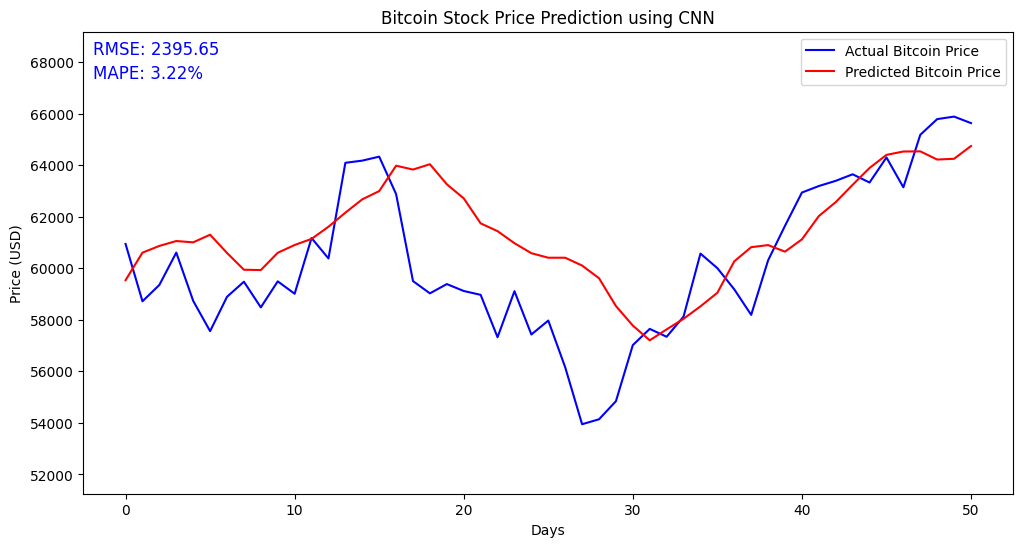

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Bitcoin Price for Next Day: $65168.98
Mean Absolute Percentage Error (MAPE): 3.22%
Root Mean Squared Error (RMSE): 2395.65
Model Accuracy: 96.78%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

btc_data = yf.download('BTC-USD', start='2024-01-01', end='2024-10-01')
btc_data = btc_data[['Close']]

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
btc_scaled = scaler.fit_transform(btc_data)

def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 20
X, y = create_sequences(btc_scaled, time_step)

# Reshape input data for CNN
X = X.reshape(X.shape[0], X.shape[1], 1)

split_ratio = 0.8
split = int(len(X) * split_ratio)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Build CNN Model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_step, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

y_pred = model.predict(X_test)

# Convert back to original scale
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100  # MAPE in percentage
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
accuracy = 100 - mape  # Approximate accuracy

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Bitcoin Price", color='blue')
plt.plot(y_pred_inv, label="Predicted Bitcoin Price", color='red')
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.ylim(min(y_test_inv) * 0.95, max(y_test_inv) * 1.05)


plt.text(0.01, 0.95, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, fontsize=12, color='blue')
plt.text(0.01, 0.90, f'MAPE: {mape:.2f}%', transform=plt.gca().transAxes, fontsize=12, color='blue')
plt.legend()
plt.title("Bitcoin Stock Price Prediction using CNN")
plt.show()

# 7. Predict Next Day Bitcoin Price
last_60_days = btc_scaled[-time_step:]
last_60_days = last_60_days.reshape(1, time_step, 1)

next_day_prediction = model.predict(last_60_days)
next_day_price = scaler.inverse_transform(next_day_prediction.reshape(-1, 1))

print(f"Predicted Bitcoin Price for Next Day: ${next_day_price[0][0]:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Model Accuracy: {accuracy:.2f}%")